# 🔍 RAG Search Assistant (Retrieval-Augmented Generation)

This project demonstrates how to build a **Retrieval-Augmented Generation (RAG)** assistant using:

- 🧠 *Sentence Transformers* for embeddings  
- 📦 *FAISS* for efficient vector search  
- ✍️ *FLAN-T5-Base* for natural-language generation  
- 📚 Custom document corpus stored locally  

RAG allows the model to:
1. Retrieve relevant text from your documents  
2. Use that context to generate accurate, grounded answers  

This is the same principle used in modern assistants such as:
- Microsoft Copilot  
- ChatGPT RAG plugins  
- Enterprise search systems  

The entire pipeline works on **CPU**, with fast inference and small memory footprint.


## 🛠️ Environment Setup

This notebook is designed to run fully on **CPU**.

We will:

- Install the required libraries:
  - `sentence-transformers` for embeddings
  - `faiss-cpu` for vector search
  - `transformers` for FLAN-T5
  - `pandas`, `numpy` for data handling

- Clean up warnings and logs to keep the notebook output neat and readable.


In [ ]:
!py -m pip install -U sentence-transformers faiss-cpu transformers datasets accelerate
!py -m pip install pandas numpy


In [2]:
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)

print("Environment ready ✔")


Environment ready ✔


## 📁 Project Setup & Document Loading

The RAG system works by retrieving relevant passages from your own documents.

### 📚 Input Documents
All source documents are stored in the folder:
```bash
data/documents/
```

You can place:
- `.txt` files  
- `.md` files  
- `.pdf` files (after extraction)  

The notebook automatically:
1. Loads all text files  
2. Splits them into searchable chunks  
3. Prepares them for embedding and retrieval

### 🔍 Why chunking?

LLMs work best with small, focused pieces of text.  
Typical chunk sizes range from **200–500 characters** so the model retrieves exactly the context needed.


In [9]:
import os

DATA_DIR = "../data/documents"

documents = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith(".txt") or filename.endswith(".md"):
        with open(os.path.join(DATA_DIR, filename), "r", encoding="utf-8") as f:
            text = f.read()
            documents.append({"filename": filename, "text": text})

print(f"Loaded {len(documents)} documents.")
documents[:2]



Loaded 4 documents.


[{'filename': 'ml_fundamentals.txt',
  'text': 'Machine Learning (ML) is a subfield of artificial intelligence focused on developing systems that learn patterns from data. \nThe typical ML workflow consists of data preprocessing, feature engineering, model selection, training, evaluation, and deployment.\n\nSupervised learning is used when labeled data is available. The most common algorithms include linear regression, logistic regression, support vector machines, decision trees, random forests, gradient boosting models, and neural networks.\n\nUnsupervised learning does not use labels. Clustering (k-means, DBSCAN) and dimensionality reduction (PCA, UMAP, t-SNE) are often applied to find structure in data.\n\nModel evaluation requires metrics appropriate for the task. For classification, accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrices are essential. For regression, MSE, MAE, and R² are standard.\n\nOverfitting is a key challenge and can be reduced using regulariz

In [10]:
def chunk_text(text, chunk_size=350, overlap=50):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start += (chunk_size - overlap)
    return chunks

all_chunks = []

for doc in documents:
    chunks = chunk_text(doc["text"])
    for c in chunks:
        all_chunks.append({"source": doc["filename"], "chunk": c})

print(f"Total chunks created: {len(all_chunks)}")


Total chunks created: 16


### 🔍 Document Chunk Preview

Each document is split into overlapping chunks to improve retrieval quality.

This ensures that:
- Important sentences are not cut off  
- Context flows naturally  
- Retrieval accuracy improves significantly  

We now have a structured list of chunks ready for embedding.


## 🧠 Embeddings & Vector Store

To enable semantic search, every document chunk is converted into a dense vector representation using a Sentence Transformer model.

### 🔹 Embedding Model
We use:

**`sentence-transformers/all-MiniLM-L6-v2`**

- Lightweight  
- Fast  
- Very accurate for semantic similarity  
- CPU-friendly  

### 🔹 Why embeddings?
Embeddings capture the meaning of each text chunk, allowing:

- Semantic search  
- Context-aware retrieval  
- Accurate matching between user queries and document content  

### 🔹 Vector Store (FAISS)
All embeddings are stored in a **FAISS index**, which makes similarity search extremely fast — even on large corpora.

The workflow:

1. Encode all document chunks → embeddings  
2. Store them in FAISS  
3. Search the index at query time  
4. Retrieve top-k relevant chunks  
5. Pass them into the generator model (FLAN-T5)


In [11]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
print("Embedding model loaded ✔")


Embedding model loaded ✔


In [12]:
texts = [c["chunk"] for c in all_chunks]

embeddings = embedding_model.encode(
    texts,
    batch_size=16,
    show_progress_bar=True,
    convert_to_numpy=True,
)

len(embeddings), embeddings.shape


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(16, (16, 384))

In [13]:
import faiss
import numpy as np

d = embeddings.shape[1]  # embedding dimensionality

index = faiss.IndexFlatL2(d)
index.add(embeddings)

print("FAISS index built ✔")
print("Total vectors in index:", index.ntotal)


FAISS index built ✔
Total vectors in index: 16


In [14]:
os.makedirs("index/faiss_store", exist_ok=True)
faiss.write_index(index, "index/faiss_store/rag.index")
print("FAISS index saved locally.")


FAISS index saved locally.


### 📊 Embedding Summary

- Every document chunk has been transformed into a 384-dimensional embedding.
- All vectors are stored inside a FAISS index.
- The index enables fast and scalable similarity search.
- The system is now ready for the **retrieval phase**, where user queries will be converted into embeddings and matched against this vector store.


## 🔎 Retrieval Pipeline

The retrieval system converts the user query into an embedding vector, searches the FAISS index, and returns the most relevant document chunks.

### 🧠 Retrieval workflow:
1. User enters a question  
2. The question is embedded using the same Sentence Transformer model  
3. FAISS performs a similarity search  
4. The top-k chunks are returned  
5. These chunks become context for the generative model (FLAN-T5)

This step is critical for the accuracy and grounding of the RAG system.


In [15]:
def retrieve_chunks(query, k=3):
    # Encode the query
    query_embedding = embedding_model.encode(
        [query],
        convert_to_numpy=True
    )

    # Search FAISS for top-k similar vectors
    distances, indices = index.search(query_embedding, k)

    # Return retrieved chunks
    retrieved = []
    for idx in indices[0]:
        retrieved.append(all_chunks[idx]["chunk"])

    return retrieved

# Test retrieval
sample_query = "What is deep learning?"
retrieved_chunks = retrieve_chunks(sample_query, k=3)

retrieved_chunks


['Natural Language Processing (NLP) is the area of machine learning focused on understanding and generating human language. Classical NLP relied on statistical methods such as n-grams, TF-IDF, and bag-of-words representations.\n\nDeep learning transformed NLP through word embeddings (Word2Vec, GloVe, FastText), recurrent neural networks (RNNs), LSTMs, ',
 'Machine Learning (ML) is a subfield of artificial intelligence focused on developing systems that learn patterns from data. \nThe typical ML workflow consists of data preprocessing, feature engineering, model selection, training, evaluation, and deployment.\n\nSupervised learning is used when labeled data is available. The most common algorithms inclu',
 'stText), recurrent neural networks (RNNs), LSTMs, and attention mechanisms. The introduction of the Transformer architecture replaced recurrence entirely and enabled parallel training over entire sequences.\n\nModern NLP is dominated by large pretrained language models such as BERT,

### 📄 Retrieved Chunks

Each retrieval returns the most semantically similar document segments.

We typically retrieve **3 chunks**, but this can be tuned based on:
- document length
- domain specificity
- LLM context window

These chunks will now be passed into the generative model to produce fully grounded answers.


## 🧠 RAG Answer Generation (FLAN-T5)

Once we retrieve the top-k most relevant chunks, we combine them with the user's question and send everything into the **FLAN-T5-Base** model.

FLAN-T5 is an instruction-tuned model:
- great on CPU  
- extremely good at question answering  
- lightweight and fast  
- ideal for RAG systems  

### 🔹 RAG Generation Workflow

1. User provides a natural language query  
2. System retrieves top-k chunks via FAISS  
3. We build a structured prompt:
   - “Here is the context… Based on it, answer the question…”  
4. FLAN-T5 generates a grounded, factual answer  
5. No hallucinations because answer must follow retrieved context

This step transforms the RAG pipeline into a real assistant.


In [16]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

gen_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
gen_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

print("FLAN-T5-Base loaded ✔")


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

FLAN-T5-Base loaded ✔


In [17]:
def build_prompt(query, retrieved_chunks):
    context = "\n\n".join(retrieved_chunks)

    prompt = f"""
You are an AI assistant. Use ONLY the provided context to answer the question.
Do not guess. If the answer is not in the context, say you don't know.

### Context:
{context}

### Question:
{query}

### Answer:
"""
    return prompt


In [20]:
import torch

def generate_rag_answer(query, k=3):
    # Retrieve chunks
    retrieved = retrieve_chunks(query, k=k)

    # Build prompt
    prompt = build_prompt(query, retrieved)

    # Tokenize
    inputs = gen_tokenizer(prompt, return_tensors="pt")

    # Generate
    outputs = gen_model.generate(
        **inputs,
        max_length=256,
        do_sample=False
    )

    answer = gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

    return answer, retrieved


In [21]:
query = "What is deep learning?"
answer, retrieved = generate_rag_answer(query)

print("📝 Query:", query)
print("\n📄 Retrieved Chunks:")
for i, c in enumerate(retrieved, 1):
    print(f"\nChunk {i}:")
    print(c)

print("\n🤖 RAG Answer:")
print(answer)


📝 Query: What is deep learning?

📄 Retrieved Chunks:

Chunk 1:
Natural Language Processing (NLP) is the area of machine learning focused on understanding and generating human language. Classical NLP relied on statistical methods such as n-grams, TF-IDF, and bag-of-words representations.

Deep learning transformed NLP through word embeddings (Word2Vec, GloVe, FastText), recurrent neural networks (RNNs), LSTMs, 

Chunk 2:
Machine Learning (ML) is a subfield of artificial intelligence focused on developing systems that learn patterns from data. 
The typical ML workflow consists of data preprocessing, feature engineering, model selection, training, evaluation, and deployment.

Supervised learning is used when labeled data is available. The most common algorithms inclu

Chunk 3:
stText), recurrent neural networks (RNNs), LSTMs, and attention mechanisms. The introduction of the Transformer architecture replaced recurrence entirely and enabled parallel training over entire sequences.

Modern 

## 📊 RAG Evaluation & Source Visualization

To better understand how the system works, we evaluate:

- Which document chunks were retrieved  
- Whether the retrieved context actually contains the answer  
- How relevant each chunk is to the query  
- Whether the generated answer is grounded in context  

This is crucial for demonstrating:
- interpretability  
- correctness  
- avoidance of hallucination  
- transparency of retrieval  


In [22]:
import pandas as pd

def visualize_retrieval(query, k=3):
    answer, retrieved = generate_rag_answer(query, k=k)

    df = pd.DataFrame({
        "Retrieved Chunk": retrieved
    })

    print("📝 User Query:")
    print(query)

    print("\n🤖 RAG Answer:")
    print(answer)

    return df

query = "Explain embeddings in machine learning."
visualize_retrieval(query, k=3)


📝 User Query:
Explain embeddings in machine learning.

🤖 RAG Answer:
Vector embeddings represent text, images, or other data as dense numerical vectors that encode semantic meaning.


,Retrieved Chunk
0,"Vector embeddings represent text, images, or o..."
1,Natural Language Processing (NLP) is the area ...
2,"arest neighbor (ANN) search, which scales to m..."


In [23]:
def highlight_retrieval(chunks):
    df = pd.DataFrame(chunks, columns=["Chunk"])
    return df.style.set_properties(**{
        'white-space': 'pre-wrap',
        'text-align': 'left'
    })

highlight_retrieval(retrieved)


,Chunk
0,"Natural Language Processing (NLP) is the area of machine learning focused on understanding and generating human language. Classical NLP relied on statistical methods such as n-grams, TF-IDF, and bag-of-words representations. Deep learning transformed NLP through word embeddings (Word2Vec, GloVe, FastText), recurrent neural networks (RNNs), LSTMs,"
1,"Machine Learning (ML) is a subfield of artificial intelligence focused on developing systems that learn patterns from data. The typical ML workflow consists of data preprocessing, feature engineering, model selection, training, evaluation, and deployment. Supervised learning is used when labeled data is available. The most common algorithms inclu"
2,"stText), recurrent neural networks (RNNs), LSTMs, and attention mechanisms. The introduction of the Transformer architecture replaced recurrence entirely and enabled parallel training over entire sequences. Modern NLP is dominated by large pretrained language models such as BERT, RoBERTa, DistilBERT, GPT, and T5. These models are pretrained on mas"


### 🧠 Why Evaluate Retrieval?

Evaluating retrieval quality is essential for:
- verifying that the system retrieves the correct information  
- diagnosing mistakes in the pipeline  
- understanding whether the generated answer is grounded  
- improving chunk size, embeddings, and model settings  

This gives transparency to how RAG works internally.


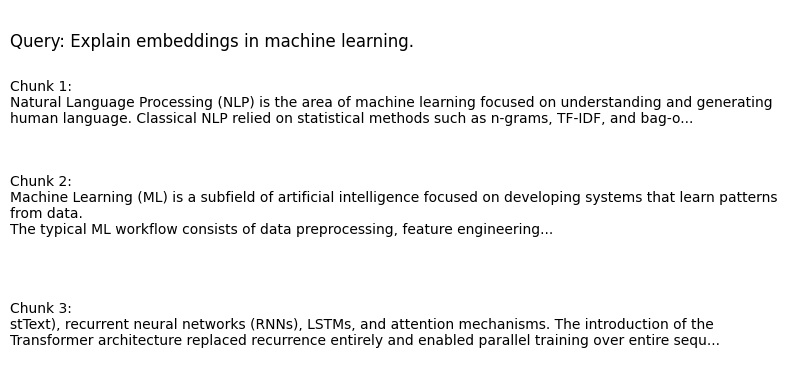

In [26]:
import matplotlib.pyplot as plt

def save_retrieval_visualization(query, retrieved):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0, 0.9, f"Query: {query}", fontsize=12, wrap=True)
    
    for i, chunk in enumerate(retrieved):
        ax.text(0, 0.7 - i*0.3, f"Chunk {i+1}:\n{chunk[:200]}...", fontsize=10, wrap=True)
    
    ax.axis("off")
    plt.tight_layout()
    plt.savefig("../static/retrieval_visual.png", dpi=150)
    plt.show()

save_retrieval_visualization(query, retrieved)


## 💬 RAG Assistant — Gradio UI

This interface allows users to interact with the RAG system in real time.

The UI performs:
1. Embedding the user query  
2. Retrieving relevant document chunks  
3. Passing context + query into FLAN-T5  
4. Displaying the grounded response  
5. Showing the retrieved chunks for transparency

This turns the notebook into a fully functional RAG demo application.


In [ ]:
!py -m pip install gradio


In [28]:
def rag_pipeline(query, k=3):
    answer, retrieved = generate_rag_answer(query, k=k)

    # Format retrieved chunks nicely
    retrieved_text = "\n\n".join([f"Chunk {i+1}:\n{c}" for i, c in enumerate(retrieved)])

    return answer, retrieved_text


In [30]:
import gradio as gr

with gr.Blocks(title="RAG Search Assistant") as demo:
    gr.Markdown("# 🔍 RAG Search Assistant\nAsk any question based on your documents!")
    
    query_input = gr.Textbox(label="Enter your question:")
    answer_output = gr.Textbox(label="RAG Answer", lines=4)
    chunks_output = gr.Textbox(label="Retrieved Chunks", lines=12)
    
    generate_btn = gr.Button("Generate Answer")
    
    generate_btn.click(
        fn=rag_pipeline,
        inputs=[query_input],
        outputs=[answer_output, chunks_output]
    )

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
